In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# csv 파일 불러오기
fake_df = pd.read_csv('C:\crawling/Fake.csv')
true_df = pd.read_csv('C:\crawling/True.csv')

In [3]:
#f ake news에 1, true news에 0을 label으로 부여한 후 label 열 생성
fake_df['label']=1
true_df['label']=0

In [4]:
# fake_df, true_df를 하나로 병합
df = pd.concat([fake_df, true_df], ignore_index=True)
df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [5]:
# X : train_df의 입력값으로 설정,  y : train_df의 결과값으로 분리
X = df.dropna()

X = df.drop('label', axis = 1)

y = df['label']

In [6]:
# 텍스트마이닝 전처리 기법을 활용한 텍스트 전처리
messages = X.copy()
messages.reset_index(inplace = True)
nltk.download('stopwords')


ps = PorterStemmer()

corpus = []

for i in range(0, len(messages)):

    review = re.sub('[^a-zA-Z]', ' ', str(messages['title'][i]))
    review = review.lower()  # 소문자화
    review = review.split() #쪼개기
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #불용어 제거
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jinhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# onehot_repr : words를 숫자로 변환
# normal_repr : words그대로 리스트로 정리 
voc_size = 5000

onehot_repr = [one_hot(words, voc_size) for words in corpus]
normal_repr = [(words, voc_size) for words in corpus]

In [8]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 1234)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# 나누어진 데이터의 크기를 확인

vectorizer = CountVectorizer()
# 단어들의 출현 빈도를 체크하기 위한 vectorizer를 생성

X_train_docs = vectorizer.fit_transform(X_train)
X_test_docs = vectorizer.transform(X_test)
print(X_train_docs.shape, X_test_docs.shape)
# X_train과 X_test의 데이터를 vectorizer를 통해 수치 벡터로 만들어 X_train_docs와 X_test_docs에 집어 넣음

X_train_docs.toarray()
X_test_docs.toarray()
# 수치 벡터로 만들어진 데이터를 넘파이 배열로 바꿈

(31428, 105601) (13470, 105601)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
# 모델의 성능을 높이기 위해서 alpha 값을 작게 1로설정
# MultinomialNB 모델을 naive_bayes에 저장
naive_bayes = MultinomialNB(alpha=1, fit_prior=True)
naive_bayes.fit(X_train_docs, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [10]:
#p redict를 사용하여 1은 가짜 뉴스 0은 진짜 뉴스가 되도록 만듦 
y_pred = naive_bayes.predict(X_test_docs)
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [11]:
# predict_proba를 사용하면 0일 가능성과 1일 가능성 모두 출력
y_pred_proba = naive_bayes.predict_proba(X_test_docs)
y_pred_proba

array([[7.68279484e-091, 1.00000000e+000],
       [4.77217768e-001, 5.22782232e-001],
       [1.70228258e-008, 9.99999983e-001],
       ...,
       [1.00000000e+000, 1.48721986e-121],
       [1.00000000e+000, 1.97450562e-018],
       [1.00000000e+000, 8.45650287e-088]])

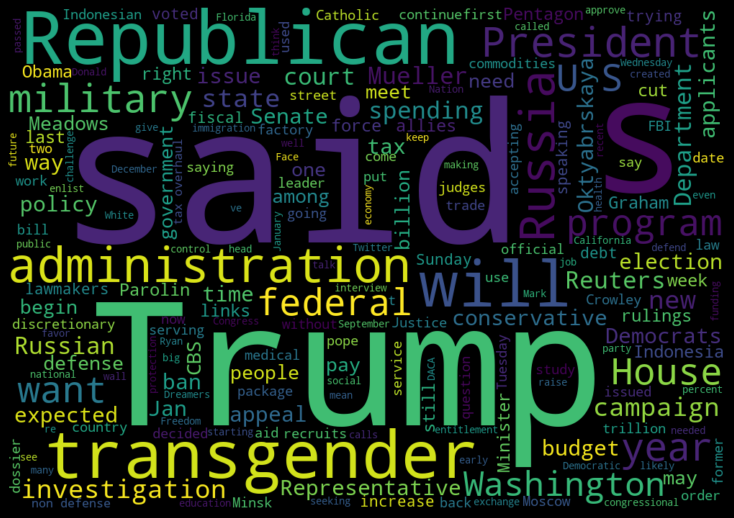

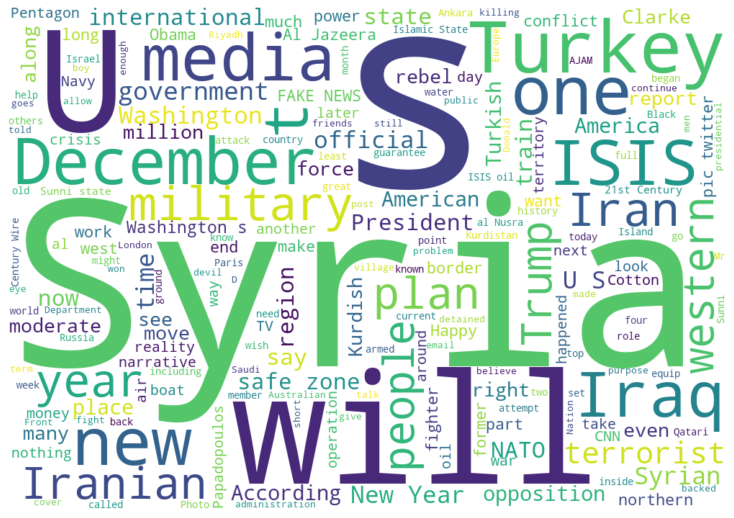

In [12]:
# 단어 구름 시각화
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
    width = 1000,
    height = 700,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(df.loc[df.label == 0,"text"].values))
    
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

wordcloud = WordCloud(
    width = 1000,
    height = 700,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(df.loc[df.label == 1,"text"].values))
    
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      6419
           1       0.96      0.95      0.95      7051

    accuracy                           0.95     13470
   macro avg       0.95      0.95      0.95     13470
weighted avg       0.95      0.95      0.95     13470

Accuarcy: 95.04


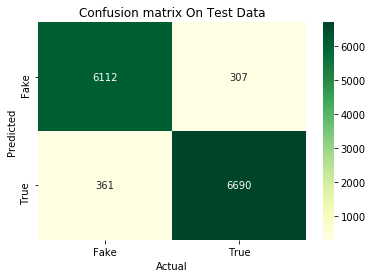

In [13]:
#matrix 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_m = confusion_matrix(y_test, y_pred)

con_m

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import accuracy_score
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

new_conm = pd.DataFrame(con_m , index = ['Fake','True'] , columns = ['Fake','True'])
sns.heatmap(new_conm,cmap= 'YlGn', annot = True, fmt='',xticklabels = ['Fake','True'], yticklabels = ['Fake','True'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()

In [20]:
# 함수 정의
def fakenews_checker(X):
    
    X = X.fillna(0)
    
    messages = X.copy()

    messages.reset_index(inplace = True)

   
    ps = PorterStemmer()

    corpus = []

    for i in range(0, len(messages)):
       

        review = re.sub('[^a-zA-Z]', ' ', str(messages['title'][i]))
        review = review.lower()
        review = review.split()

        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)

  
    voc_size = 5000

    onehot_repr = [one_hot(words, voc_size) for words in corpus]
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre')
    X_final = np.array(embedded_docs)
    
    if y_pred_proba[0][1]>0.7:
        print('이 News는 Fake입니다!')

    

In [21]:
# 테스트로 새로운 데이터를 discriminator 모델에 넣음
test_df = pd.read_csv('C:\crawling/test_news.csv',encoding='cp949')

In [22]:
fakenews_checker(test_df)

이 News는 Fake입니다!
